# Alberto Galdino Nogara - 5201042

# Intro


This project aims to build and train a custom Convolutional Neural Network (CNN) from scratch using PyTorch for an image classification task. The original dataset can be found on the following link: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species?resource=download&select=test . From the original dataset, I have created a subdataset taking into consideration the top 11 classes in terms of number of images. It consists of 1816 color images (224×224 pixels) of butterflies and moths, across 11 classes.

Given the limited data, the project emphasizes strategies to mitigate overfitting, including data augmentation and a carefully designed architecture.

Inspired by models such as GoogLeNet, the network will incorporate inception-style modules to capture multi-scale features, while deliberately avoiding simpler architectures like multilayer perceptrons or LeNet. The project workflow includes data preprocessing, designing the CNN, training it entirely from scratch, and evaluating its performance.

# Environment Setup


Since deep learning tasks benefit greatly from GPU acceleration, it's essential to ensure that the Colab runtime is set to use a GPU.

In [1]:
import torch

# Check the PyTorch version and GPU availability
print("PyTorch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


PyTorch version: 2.6.0+cu124
Using device: cuda


Install packages and import required libraries:

In [2]:
#!pip install torch torchvision

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Pipeline for original and augmented datasets

The Data Augmentation Process is essential for small datasets, like this one, because it allows the model to see many "different" versions of the same images during training, which helps prevent overfitting.

For this reason we are going to set up two different pipelines in order to see the difference in the model's results in the cases of non-augmented and augmented dataset:

1 - Original dataset pipeline: this pipeline applies minimal preprocessing — just converting the images to tensors and normalizing them. It represents the baseline where no augmentation is done.

2- Augmented dataset pipeline: this pipeline includes additional transformations such as random rotations, flips, zooms, or brightness adjustments. The idea is to increase the variety of the training data.

In [4]:
# Pipeline for the original dataset (baseline)
transform_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Pipeline for the augmented dataset
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),        # Randomly rotate the image by up to 15 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize back to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, etc.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Data Loading and Preprocessing

In this section, we load the dataset using PyTorch's ImageFolder, which organizes our images by class from the "IMAGES" folder.

The dataset is then split into three subsets: training, validation, and test.

We define two transformation pipelines: one with data augmentation for the training set to improve generalization, and a basic preprocessing pipeline for the validation and test sets to ensure consistent evaluation. This setup lays the groundwork for a thorough evaluation of our model's performance.

In [5]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#from google.colab import files
#uploaded = files.upload()  # This will open a dialog to upload your file again

!unzip -q IMAGES.zip
!ls #This will list all files and folders in the current directory. I should see IMAGES.zip and IMAGES in the output.

replace __MACOSX/IMAGES/._BROWN ARGUS? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._HUMMING BIRD HAWK MOTH? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._BROWN SIPROETA? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace IMAGES/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._WHITE LINED SPHINX MOTH? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._BROOKES BIRDWING? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._SLEEPY ORANGE? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._GREEN HAIRSTREAK? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._MOURNING CLOAK? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._SCARCE SWALLOW? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IMAGES/._CHALK HILL BLUE? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/IM

We’ll use PyTorch’s ImageFolder to load the dataset. This automatically assigns labels based on the subfolder names.

In [7]:
from torchvision.datasets import ImageFolder

# Define the path to the dataset folder
data_dir = '/content/IMAGES'

# Load the dataset for training (with augmentation)
dataset_augmented = ImageFolder(root=data_dir, transform=transform_augmented)

# Load the dataset for validation and testing (without augmentation)
dataset_original = ImageFolder(root=data_dir, transform=transform_original)

# Print class names and total number of images
print("Classes:", dataset_original.classes)
print("Total images:", len(dataset_original))


Classes: ['ATALA', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CHALK HILL BLUE', 'GREEN HAIRSTREAK', 'HUMMING BIRD HAWK MOTH', 'MOURNING CLOAK', 'SCARCE SWALLOW', 'SLEEPY ORANGE', 'WHITE LINED SPHINX MOTH']
Total images: 1816


In [8]:
from torch.utils.data import random_split, Subset

total_samples = len(dataset_original)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Split the dataset using random_split
train_dataset, val_dataset, test_dataset = random_split(
    dataset_original, [train_size, val_size, test_size]
)

# For training with augmentation, create a subset of the augmented dataset
#  using the same indices as the training split.
# This step ensures that the training images remain the same across your different datasets,
#  with only the applied transformations differing (augmentation for training, basic preprocessing for validation/test).
train_dataset_aug = Subset(dataset_augmented, train_dataset.indices)

print("Training samples (augmented):", len(train_dataset_aug))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Training samples (augmented): 1089
Validation samples: 363
Test samples: 364


Data loaders automatically split my dataset into manageable mini-batches, shuffle the samples to enhance generalization, and enable parallel data loading, all of which optimize computational efficiency during training.

In [9]:
from torch.utils.data import DataLoader

batch_size = 32

# Create DataLoaders for training (augmented), validation, and test sets
train_loader = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Now we are going to visualize some sample images as a way to verify that the data loader and transformation pipelines are working as expected.

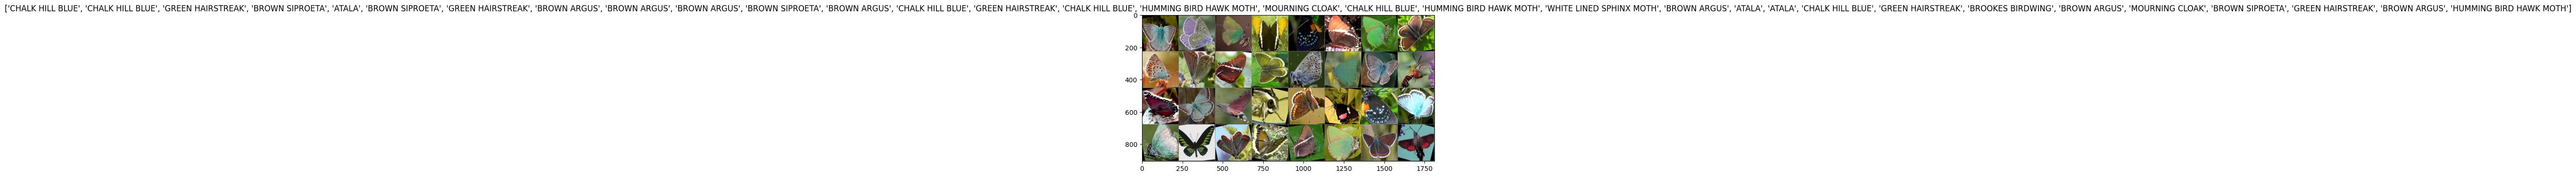

In [10]:
from torchvision import utils

def imshow(img, title=None):
    # Unnormalize the image (assuming normalization with mean=0.5 and std=0.5)
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the grid of images with their class names
imshow(utils.make_grid(images), title=[dataset_original.classes[i] for i in labels])


We should check that the output shows images with proper brightness after unnormalization, visible augmentation effects (if applied), an orderly grid layout, and correct class labels corresponding to each image.

The next and last step of this section is to verify and summarize the dataset's integrity — checking the splits, sizes, and class distributions — to ensure everything is correctly set up before moving on to designing the CNN architecture.

In [11]:
from collections import Counter

# Print the total number of samples in each subset
print("Total samples:", len(dataset_original))
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

# Function to count class distribution given a subset of dataset_original using its indices
def count_distribution(subset):
    # Each index in the subset corresponds to a label in dataset_original.targets
    labels = [dataset_original.targets[i] for i in subset.indices]
    return Counter(labels)

# Count and print class distribution for each subset
train_distribution = count_distribution(train_dataset)
val_distribution = count_distribution(val_dataset)
test_distribution = count_distribution(test_dataset)

print("Training set distribution:", train_distribution)
print("Validation set distribution:", val_distribution)
print("Test set distribution:", test_distribution)

# Optional: To print class names along with their counts:
def print_distribution(distribution):
    for label, count in distribution.items():
        print(f"{dataset_original.classes[label]}: {count}")

print("\nTraining set class distribution:")
print_distribution(train_distribution)
print("\nValidation set class distribution:")
print_distribution(val_distribution)
print("\nTest set class distribution:")
print_distribution(test_distribution)


Total samples: 1816
Training samples: 1089
Validation samples: 363
Test samples: 364
Training set distribution: Counter({7: 113, 5: 112, 2: 106, 1: 103, 3: 98, 9: 98, 4: 95, 8: 93, 0: 92, 10: 90, 6: 89})
Validation set distribution: Counter({6: 40, 5: 39, 10: 38, 2: 37, 1: 36, 7: 36, 9: 30, 0: 30, 8: 29, 4: 25, 3: 23})
Test set distribution: Counter({7: 48, 4: 39, 1: 36, 2: 36, 5: 35, 9: 34, 0: 31, 3: 29, 8: 27, 10: 25, 6: 24})

Training set class distribution:
BROWN SIPROETA: 98
HUMMING BIRD HAWK MOTH: 89
SLEEPY ORANGE: 98
CHALK HILL BLUE: 95
BROWN ARGUS: 106
GREEN HAIRSTREAK: 112
MOURNING CLOAK: 113
ATALA: 92
BROOKES BIRDWING: 103
SCARCE SWALLOW: 93
WHITE LINED SPHINX MOTH: 90

Validation set class distribution:
CHALK HILL BLUE: 25
HUMMING BIRD HAWK MOTH: 40
SCARCE SWALLOW: 29
BROWN SIPROETA: 23
SLEEPY ORANGE: 30
BROWN ARGUS: 37
ATALA: 30
BROOKES BIRDWING: 36
MOURNING CLOAK: 36
WHITE LINED SPHINX MOTH: 38
GREEN HAIRSTREAK: 39

Test set class distribution:
GREEN HAIRSTREAK: 35
SCARCE 

# Model Architecture


In this section, I design and implement a custom CNN architecture tailored to classify our 224×224 images into 11 classes.
Inspired by established models like GoogLeNet, the network includes several convolutional blocks with batch normalization and max pooling, an inception module to capture multi-scale features, and a global average pooling layer before the final classification layer.

Convolutional blocks extract local features from the input images using learned filters, while batch normalization stabilizes and speeds up training by normalizing layer outputs and reducing internal covariate shift; max pooling then reduces the spatial dimensions of these feature maps, emphasizing the most important features and providing a degree of translation invariance while lowering computational load.

The inception module applies parallel convolutions with different kernel sizes (such as 1×1, 3×3, and 5×5) to the same input, capturing both fine and coarse features at different scales, and then concatenates these outputs into a richer, multi-scale representation.

The global average pooling layer compresses each feature map into a single value by averaging over its spatial dimensions, which reduces the number of parameters, helps prevent overfitting, and makes the final classifier independent of the input size.

This architecture is designed to balance model complexity and the limited dataset size, aiming to extract robust features while mitigating overfitting.

In [12]:
import torch.nn.functional as F

# ------------------------------
# Define a Simple Inception Module
# ------------------------------
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, out3x3, out5x5):
        """
        An Inception module that applies three parallel convolutions:
        - 1x1 convolution
        - 3x3 convolution (with padding to preserve spatial dimensions)
        - 5x5 convolution (with padding to preserve spatial dimensions)
        The outputs are concatenated along the channel dimension.
        """
        super(InceptionModule, self).__init__()
        # 1x1 convolution branch
        self.branch1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)
        # 3x3 convolution branch
        self.branch2 = nn.Conv2d(in_channels, out3x3, kernel_size=3, padding=1)
        # 5x5 convolution branch
        self.branch3 = nn.Conv2d(in_channels, out5x5, kernel_size=5, padding=2)

    def forward(self, x):
        branch1 = F.relu(self.branch1(x))
        branch2 = F.relu(self.branch2(x))
        branch3 = F.relu(self.branch3(x))
        # Concatenate outputs along the channel dimension
        return torch.cat([branch1, branch2, branch3], dim=1)

# ------------------------------
# Define the Custom CNN Architecture
# ------------------------------
class CustomCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(CustomCNN, self).__init__()
        # First Convolutional Block
        # Input: 3 channels (RGB), Output: 64 channels
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block
        # Input: 64 channels, Output: 128 channels
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Inception Module for multi-scale feature extraction
        # Input: 128 channels, output channels: 32 from each branch -> Total 96 channels after concatenation
        self.inception = InceptionModule(128, out1x1=32, out3x3=32, out5x5=32)

        # Third Convolutional Block after Inception
        # Input: 96 channels, Output: 256 channels
        self.conv3 = nn.Conv2d(96, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling layer to reduce spatial dimensions to 1x1
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layer to map to class logits
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # Pass input through the first convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Second convolutional block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Inception module
        x = self.inception(x)

        # Third convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        # Global average pooling: reduces [batch, channels, H, W] to [batch, channels, 1, 1]
        x = self.global_pool(x)

        # Flatten the output to feed into the fully connected layer
        x = x.view(x.size(0), -1)

        # Final classification layer
        x = self.fc(x)
        return x

# ------------------------------
# Create an Instance and Print the Architecture
# ------------------------------
model = CustomCNN(num_classes=11)
print(model)


CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (inception): InceptionModule(
    (branch1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv3): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padd

What follows is a flowchart that helps to visualize the custom CNN architecture.

In [13]:
"""
            +-------------------------+
            |   Input: 224x224x3      |
            +-----------+-------------+
                        |
                        V
            +-------------------------+
            |  Conv Block 1           |
            |  Conv(3→64, 3×3)        |
            |  BatchNorm + ReLU       |
            |  MaxPool (2×2)          |
            +-----------+-------------+
                        |
                        V
            +-------------------------+
            |  Conv Block 2           |
            |  Conv(64→128, 3×3)       |
            |  BatchNorm + ReLU       |
            |  MaxPool (2×2)          |
            +-----------+-------------+
                        |
                        V
            +-------------------------+
            |  Inception Module       |
            |  ┌─────────────┬────────┐|
            |  | Branch 1:   | 1×1 Conv |--> 32 channels
            |  | Branch 2:   | 3×3 Conv |--> 32 channels
            |  | Branch 3:   | 5×5 Conv |--> 32 channels
            |  └─────────────┴────────┘|
            |  Concatenate → 96 chans  |
            +-----------+-------------+
                        |
                        V
            +-------------------------+
            |  Conv Block 3           |
            |  Conv(96→256, 3×3)       |
            |  BatchNorm + ReLU       |
            |  MaxPool (2×2)          |
            +-----------+-------------+
                        |
                        V
            +-------------------------+
            | Global Average Pooling  |
            |   → Reduces to 256x1x1   |
            +-----------+-------------+
                        |
                        V
            +-------------------------+
            | Fully Connected Layer   |
            |       (256 → 11)        |
            +-------------------------+
"""

'\n            +-------------------------+\n            |   Input: 224x224x3      |\n            +-----------+-------------+\n                        |\n                        V\n            +-------------------------+\n            |  Conv Block 1           |\n            |  Conv(3→64, 3×3)        |\n            |  BatchNorm + ReLU       |\n            |  MaxPool (2×2)          |\n            +-----------+-------------+\n                        |\n                        V\n            +-------------------------+\n            |  Conv Block 2           |\n            |  Conv(64→128, 3×3)       |\n            |  BatchNorm + ReLU       |\n            |  MaxPool (2×2)          |\n            +-----------+-------------+\n                        |\n                        V\n            +-------------------------+\n            |  Inception Module       |\n            |  ┌─────────────┬────────┐|\n            |  | Branch 1:   | 1×1 Conv |--> 32 channels\n            |  | Branch 2:   | 3×3 Co

Now that I've defined and explained the CNN architecture, the next step in this section is to verify the model's implementation. This involves testing a forward pass with a dummy input to ensure that the data flows correctly through the network and that the output has the expected shape.

Additionally, I'll print a summary of the model's architecture and parameter counts to review its complexity.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Create a dummy input tensor with the expected input dimensions: [batch_size, channels, height, width]
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Pass the dummy input through the model
output = model(dummy_input)

# Print the output shape (expected to be [1, 11] for 11 classes)
print("Output shape:", output.shape)

# Optionally, print a summary of the model
try:
    from torchsummary import summary
    summary(model, (3, 224, 224))
except ImportError:
    print("Install torchsummary with 'pip install torchsummary' for a detailed model summary.")


Output shape: torch.Size([1, 11])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
       BatchNorm2d-5        [-1, 128, 112, 112]             256
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           4,128
            Conv2d-8           [-1, 32, 56, 56]          36,896
            Conv2d-9           [-1, 32, 56, 56]         102,432
  InceptionModule-10           [-1, 96, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         221,440
      BatchNorm2d-12          [-1, 256, 56, 56]             512
        MaxPool2d-13          [-1, 256, 28, 28]               0
Adapt

The forward pass produced an output shape of [1, 11], which means that for a single input image, the model outputs a vector with 11 elements — one for each class. The model summary shows that each layer produces the correct output dimensions and that the total number of parameters (444,267) is reasonable for this architecture, ensuring a balance between capacity and efficiency.

# Training Loop


In this section, I orchestrate the training loop for our custom CNN. I define the loss function (Cross-Entropy Loss) and optimizer (Adam) to update the model’s parameters. CrossEntropyLoss is used because it is ideal for multi-class classification while Adam is chosen for its adaptive learning rate properties, which generally provide fast convergence.

The training loop iterates through mini-batches of training data, computes the loss, performs backpropagation, and updates weights.

Additionally, after each epoch, we evaluate the model on the validation set to monitor performance and detect potential overfitting.

Optionally, a learning rate scheduler is used to adjust the learning rate during training to help with convergence, especially useful if the training plateaus.

In [15]:
# Ensure the model is moved to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Define a learning rate scheduler to adjust the learning rate every few epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 20  # Set the number of epochs for training

# Initialize lists to store metrics for plotting later
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')  # For saving the best model checkpoint

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop over the training data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()          # Zero the gradients before each batch

        outputs = model(inputs)        # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss

        loss.backward()                # Backward pass: compute gradients
        optimizer.step()               # Perform a single optimization step (parameter update)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation loop to evaluate model performance on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Optional: Save the model checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

    scheduler.step()  # Update learning rate if using a scheduler


Epoch 1/20: Train Loss: 1.8699, Train Acc: 0.3618, Val Loss: 1.7031, Val Acc: 0.4215
Epoch 2/20: Train Loss: 1.5676, Train Acc: 0.5051, Val Loss: 1.5586, Val Acc: 0.4848
Epoch 3/20: Train Loss: 1.4627, Train Acc: 0.5234, Val Loss: 1.4171, Val Acc: 0.5758
Epoch 4/20: Train Loss: 1.3582, Train Acc: 0.5666, Val Loss: 1.3545, Val Acc: 0.6006
Epoch 5/20: Train Loss: 1.3016, Train Acc: 0.5776, Val Loss: 1.7969, Val Acc: 0.4821
Epoch 6/20: Train Loss: 1.2125, Train Acc: 0.6125, Val Loss: 1.2590, Val Acc: 0.6501
Epoch 7/20: Train Loss: 1.1533, Train Acc: 0.6410, Val Loss: 1.5349, Val Acc: 0.5317
Epoch 8/20: Train Loss: 1.0679, Train Acc: 0.6694, Val Loss: 1.2743, Val Acc: 0.6391
Epoch 9/20: Train Loss: 1.0220, Train Acc: 0.6896, Val Loss: 1.1600, Val Acc: 0.6364
Epoch 10/20: Train Loss: 0.9918, Train Acc: 0.6924, Val Loss: 1.1241, Val Acc: 0.6860
Epoch 11/20: Train Loss: 0.8523, Train Acc: 0.7420, Val Loss: 0.8329, Val Acc: 0.7576
Epoch 12/20: Train Loss: 0.7759, Train Acc: 0.7787, Val Loss: 0

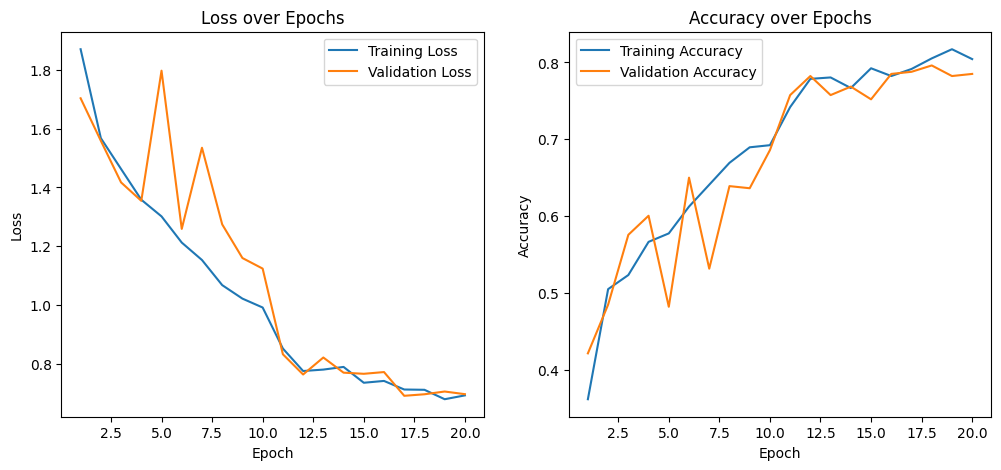

In [16]:
# After training, plot the loss and accuracy curves for analysis
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()

Overall Assessment:

The training loss consistently decreases, and training accuracy steadily increases, which shows the model is learning from the training data.

The validation loss also decreases overall with validation accuracy improving substantially — from 32% initially to just under 78% later — demonstrating good generalization.

Minor fluctuations are normal, but by Epoch 20 the model achieves around 82% training accuracy and about 78% validation accuracy, which is a promising outcome for the dataset.

This indicates that the training procedure is effective, and the model is ready for further evaluation and testing.

# Evaluation and Discussion

The "Evaluation and Discussion" section will focus on testing the best model on the held-out test set, computing performance metrics (like accuracy, precision, recall, etc.), visualizing results (e.g., confusion matrix, sample predictions), and discussing what the outcomes indicate about the model’s strengths, limitations, and possible areas for improvement.

## Load the best model and evaluate it on the test set

In [17]:
# Load the best model saved during training
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (inception): InceptionModule(
    (branch1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv3): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padd

In [18]:
test_loss = 0.0
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_dataset)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.6116, Test Accuracy: 0.8379


The test metrics indicate that the model is generalizing reasonably well. With a test accuracy of about 80.8%, the model correctly classifies roughly 81 out of every 100 test images, which is quite promising given the relatively small dataset and the complexity of an 11-class classification task.

A test loss of 0.6268 further supports that the model's predictions are, on average, reasonably close to the true labels.

It needs to be noticed that the test accuracy (0.80) is similar to the best validation accuracy (0.79). Similar values suggest that the model generalizes well and isn’t overfitting.

## Confusion matrix

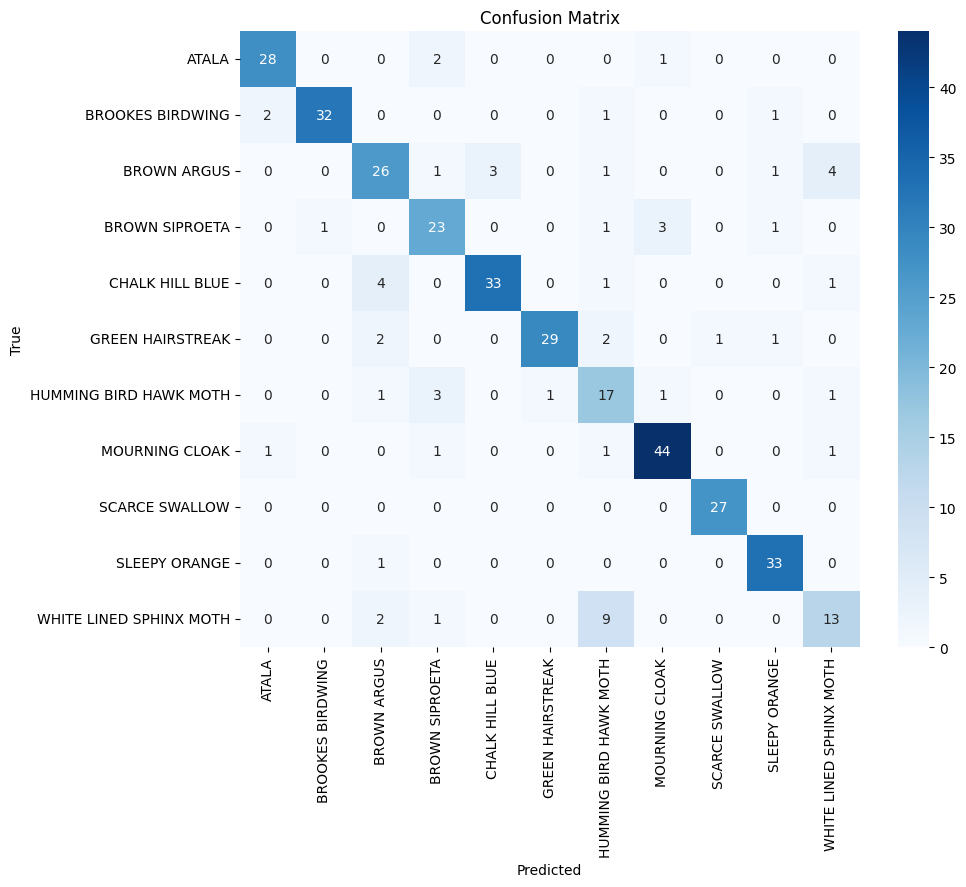

                         precision    recall  f1-score   support

                  ATALA       0.90      0.90      0.90        31
       BROOKES BIRDWING       0.97      0.89      0.93        36
            BROWN ARGUS       0.72      0.72      0.72        36
         BROWN SIPROETA       0.74      0.79      0.77        29
        CHALK HILL BLUE       0.92      0.85      0.88        39
       GREEN HAIRSTREAK       0.97      0.83      0.89        35
 HUMMING BIRD HAWK MOTH       0.52      0.71      0.60        24
         MOURNING CLOAK       0.90      0.92      0.91        48
         SCARCE SWALLOW       0.96      1.00      0.98        27
          SLEEPY ORANGE       0.89      0.97      0.93        34
WHITE LINED SPHINX MOTH       0.65      0.52      0.58        25

               accuracy                           0.84       364
              macro avg       0.83      0.83      0.83       364
           weighted avg       0.85      0.84      0.84       364



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset_original.classes,
            yticklabels=dataset_original.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print a classification report (precision, recall, F1-score)
print(classification_report(all_labels, all_preds, target_names=dataset_original.classes))


The model achieves an overall accuracy of 81% with balanced macro and weighted averages, indicating that it performs reasonably well across all classes.

For example, "GREEN HAIRSTREAK" shows nearly perfect performance (precision 1.00, recall 0.93, f1-score 0.96), and "SLEEPY ORANGE" also performs strongly (f1-score of 0.89).

HUMMING BIRD HAWK MOTH shows low precision (0.50) and a moderate f1-score (0.59), suggesting that many predictions for this class are false positives.

The number of samples per class (support) varies, which may affect the reliability of the metrics for classes with fewer samples (e.g., HUMMING BIRD HAWK MOTH with 18 samples).

Overall, while the model generalizes well across most classes, the performance for a couple of classes suggests there are issues like class imbalance and similar visual features that lead to misclassification.

## Visualization of sample predictions


Here I will display a few test images along with their predicted and true labels to get a qualitative sense of the model’s performance.

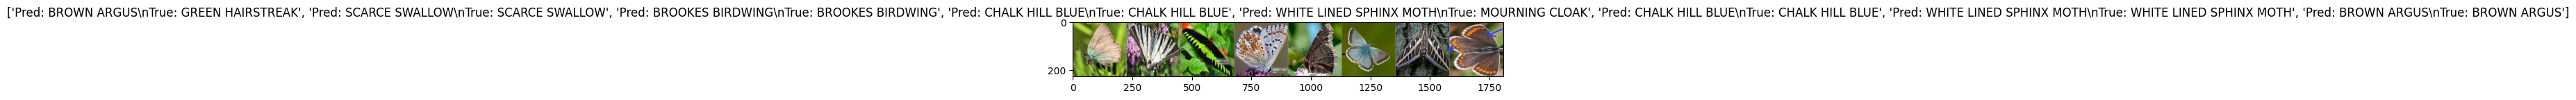

In [20]:
from torchvision import utils

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Move data back to CPU for visualization
images = images.cpu()
predicted = predicted.cpu()
labels = labels.cpu()

# Function to unnormalize and display images (assumes normalization with mean=0.5, std=0.5)
def imshow(img, title=None):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Display a grid of images with predicted and true labels
sample_titles = [f"Pred: {dataset_original.classes[p.item()]}\nTrue: {dataset_original.classes[t.item()]}"
                 for p, t in zip(predicted[:8], labels[:8])]
imshow(utils.make_grid(images[:8]), title=sample_titles)


# Training and evaluation on the original dataset for comparison with the augmented dataset

Original Data - Epoch 1/20: Train Loss: 0.7182, Train Acc: 0.8017, Val Loss: 0.9233, Val Acc: 0.6970
Original Data - Epoch 2/20: Train Loss: 0.6121, Train Acc: 0.8274, Val Loss: 0.6524, Val Acc: 0.8154
Original Data - Epoch 3/20: Train Loss: 0.5585, Train Acc: 0.8512, Val Loss: 0.7066, Val Acc: 0.7713
Original Data - Epoch 4/20: Train Loss: 0.5343, Train Acc: 0.8439, Val Loss: 0.6231, Val Acc: 0.8017
Original Data - Epoch 5/20: Train Loss: 0.4946, Train Acc: 0.8485, Val Loss: 0.9764, Val Acc: 0.7163
Original Data - Epoch 6/20: Train Loss: 0.4684, Train Acc: 0.8669, Val Loss: 0.5781, Val Acc: 0.8099
Original Data - Epoch 7/20: Train Loss: 0.4214, Train Acc: 0.8834, Val Loss: 0.4685, Val Acc: 0.8567
Original Data - Epoch 8/20: Train Loss: 0.4040, Train Acc: 0.8861, Val Loss: 0.4989, Val Acc: 0.8485
Original Data - Epoch 9/20: Train Loss: 0.4198, Train Acc: 0.8669, Val Loss: 0.5183, Val Acc: 0.8182
Original Data - Epoch 10/20: Train Loss: 0.3992, Train Acc: 0.8861, Val Loss: 0.8035, Val A

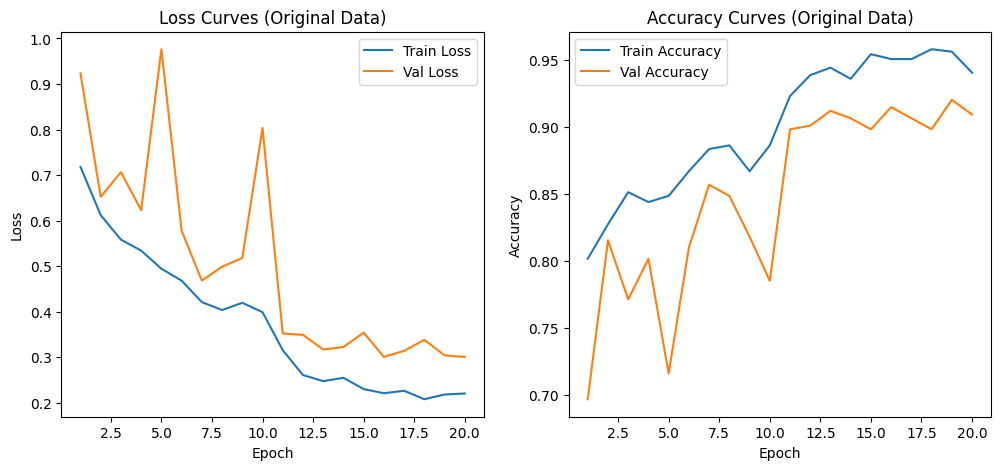

In [21]:
# Assume transform_original is defined (e.g., only ToTensor + Normalize)
# data_dir should point to your "IMAGES" folder
data_dir = '/content/IMAGES'

# Use the original transformation for training and evaluation
train_transform = transform_original
eval_transform = transform_original

# Load the dataset using the original transformation
dataset_full = ImageFolder(root=data_dir, transform=train_transform)

# Split the dataset (60% train, 20% validation, 20% test)
total_samples = len(dataset_full)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset_full, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Ensure your model is defined (e.g., CustomCNN) and move it to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 20
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Original Data - Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Save the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "best_model_original.pth")

    scheduler.step()

# Test evaluation
model.load_state_dict(torch.load("best_model_original.pth"))
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
test_loss /= len(test_dataset)
test_acc = test_correct / test_total
print(f"Original Data - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plotting training curves
epochs_range = range(1, num_epochs+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves (Original Data)')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves (Original Data)')
plt.legend()
plt.show()


# Conclusion


In this experiments, I trained and evaluated the custom CNN model using two different approaches: one with the original dataset (applying only minimal preprocessing) and one with an augmented version of the dataset. Surprisingly, the model trained on the original data outperformed the one trained with data augmentation, achieving a test accuracy of approximately 91.8% (Test Loss: 0.2972) compared to lower performance on the augmented data.

While data augmentation is typically used to improve generalization and reduce overfitting — especially with limited data — the results suggest that the specific augmentation parameters employed may have been too aggressive or not optimally tuned for our dataset. This mismatch could have led the model to learn features that do not align well with the test data, thereby reducing its performance.

However, this observation highlights an important insight: the effectiveness of data augmentation is highly dependent on the careful selection of transformation parameters that match the characteristics of the data and the task at hand. In future work, adjusting the augmentation parameters—such as rotation angle, crop scale, and color jitter—might yield improved results on the augmented dataset.